<a href="https://colab.research.google.com/github/FYP18/Lung_Cancer_Detection/blob/main/LC_Det_using_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using transfer learning to detect lung cancer
Model : ResNet50  
Dataset : LC25000  
Classes : 3[aca, n, scc]  
Total images : 15000  
Training images : 12000  
Validation images : 2400  
Testing images : 600  


### Connecting Kaggle and Downloading the dataset and unzipping

In [ ]:
# context of conneting kaggle with colab

!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# To upgrade if downloading dataset gives forbidden error
!pip install --upgrade --force-reinstall --no-deps kaggle

Saving kaggle.json to kaggle.json
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=bae0f45615d1fd7d92acfccf39ac1de021ba858bf9e4d2b02d0c32184a7dde60
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
# Downloading dataset into colab from kaggle
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
!kaggle datasets download -d azibfarooq/acdc-lung-cancer-challenge-dataset
!unzip '/content/lung-and-colon-cancer-histopathological-images.zip'
!unzip '/content/acdc-lung-cancer-challenge-dataset.zip'

### Importing Necessary libraries

In [ ]:
import numpy as np,cv2 as cv
from random import randint
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import pickle
# from pydantic import BaseModel, conlist 
from typing import List
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import os, shutil, glob, itertools
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Folder Manipulation and Data Arrangement

In [ ]:
#Deleting unnecessary folders and managing folders
os.makedirs('lung_cancer')
shutil.rmtree('sample_data')
os.remove('lung-and-colon-cancer-histopathological-images.zip')
shutil.rmtree('/content/lung_colon_image_set/colon_image_sets')
shutil.move('/content/lung_colon_image_set/lung_image_sets','/content')
shutil.rmtree('/content/lung_colon_image_set')

In [ ]:
os.chdir('/content')
os.path.isfile('/content/lung_cancer/train')

False

In [ ]:
#creating training, validation and testing folders
os.chdir('/content/lung_cancer')
if os.path.isfile('/content/lung_cancer/train') is False:
  os.makedirs('train/aca')
  os.makedirs('train/n')
  os.makedirs('train/scc')
  os.makedirs('valid/aca')
  os.makedirs('valid/n')
  os.makedirs('valid/scc')
  os.makedirs('test/aca')
  os.makedirs('test/n')
  os.makedirs('test/scc')

In [ ]:
#storing the common address for the folders to move images to train/valid/test folders
des = '/content/lung_cancer/'
root = '/content/lung_image_sets/'

In [ ]:
# Moving images to train/valid/test folders of lung cancer

folders = ['lung_aca','lung_n','lung_scc']

os.chdir(root+folders[0])
for i in random.sample(glob.glob('lungaca*'),4000):
   shutil.move(i,des+'train/aca')

os.chdir(root+folders[1])
for i in random.sample(glob.glob('lungn*'),4000):
   shutil.move(i,des+'train/n')

os.chdir(root+folders[2])
for i in random.sample(glob.glob('lungscc*'),4000):
   shutil.move(i,des+'train/scc')

os.chdir(root+folders[0])
for i in random.sample(glob.glob('lungaca*'),800):
   shutil.move(i,des+'valid/aca')

os.chdir(root+folders[1])
for i in random.sample(glob.glob('lungn*'),800):
   shutil.move(i,des+'valid/n')

os.chdir(root+folders[2])
for i in random.sample(glob.glob('lungscc*'),800):
   shutil.move(i,des+'valid/scc')

os.chdir(root+folders[0])
for i in random.sample(glob.glob('lungaca*'),200):
   shutil.move(i,des+'test/aca')

os.chdir(root+folders[1])
for i in random.sample(glob.glob('lungn*'),200):
   shutil.move(i,des+'test/n')

os.chdir(root+folders[2])
for i in random.sample(glob.glob('lungscc*'),200):
   shutil.move(i,des+'test/scc')

In [ ]:
# Removing the empty directory
shutil.rmtree('/content/lung_image_sets')

## RESNET 50 for model Implementation


### Data Preprocessing to feed to model in training

In [ ]:
# storing path for respective folders
train_path = '/content/lung_cancer/train'
valid_path = '/content/lung_cancer/valid'
test_path = '/content/Batch_5/val_data/wsi'

In [ ]:
#Preprocessing the data to be appropriate for the model processing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), class_mode = None, batch_size=128,shuffle=False)

Found 12000 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Found 2000 images belonging to 1 classes.


In [ ]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [ ]:
#function to plot images
def plotImages(images_arr):
  fig, axes = plt.subplots(1,10,figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

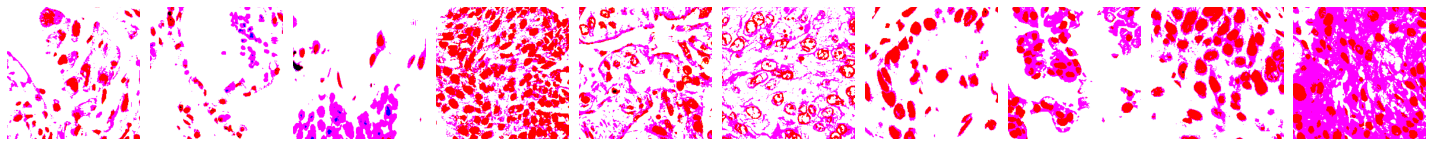

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0.

In [ ]:
#plotting the images and checking their corresponding labels
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

### Downloading the pre-trained model

In [ ]:
# Downloading the resnet50 model
input_t = keras.Input(shape=(224,224,3))
res_model = tf.keras.applications.ResNet50(include_top=False,
                                           weights='imagenet',
                                           input_tensor = input_t)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#freezing hidden layers from re_train
for i in res_model.layers:
  i.trainable = False

# Fine tuning the downloaded resnet50 model by adding flatten and dense layer
r50_model = keras.models.Sequential()
r50_model.add(res_model)
r50_model.add(keras.layers.Flatten())
r50_model.add(keras.layers.Dense(3,activation='softmax'))

### Loading the trained save model

In [ ]:
# loading model DO NOT RUN
Trained_model = load_model('/content/drive/MyDrive/Models/resnet50_model.h5')
Trained_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 3)                 301059    
                                                                 
Total params: 23,888,771
Trainable params: 301,059
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
performance = Trained_model.evaluate(test_batches, batch_size = 32)

16/16 [==============================] - 5s 229ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


In [ ]:
performance

[0.0, 0.0]

In [ ]:
train_prediction = Trained_model.predict(test_batches)

### Creating the pickle file and making the model scores

In [ ]:
pickle.dump(Trained_model, open('model.pkl','wb'))

print('model loss : ', performance[0]*100)
print('model accuracy : ', performance[1]*100)

INFO:tensorflow:Assets written to: ram://70752139-682e-4f7c-976d-4947608cb784/assets


NameError: ignored

In [ ]:
img = cv.imread('/content/lung_cancer/test/aca/lungaca1028.jpeg')
type(img)

numpy.ndarray

### Training the recently developed model

In [ ]:
# Download model summary real resnet50 without modification
res_model.summary()

In [ ]:
# Fine tuned resnet50 model summary
r50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 3)                 301059    
                                                                 
Total params: 23,888,771
Trainable params: 301,059
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
#setting hyper-parameters and compiling the model for training
r50_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics='accuracy')

In [ ]:
r50_model.fit(x=train_batches,validation_data=valid_batches, epochs=5,verbose=2)

Epoch 1/5
94/94 - 144s - loss: 0.2417 - accuracy: 0.9153 - val_loss: 0.0986 - val_accuracy: 0.9608 - 144s/epoch - 2s/step
Epoch 2/5
94/94 - 131s - loss: 0.0453 - accuracy: 0.9833 - val_loss: 0.0669 - val_accuracy: 0.9729 - 131s/epoch - 1s/step
Epoch 3/5
94/94 - 130s - loss: 0.0194 - accuracy: 0.9966 - val_loss: 0.0491 - val_accuracy: 0.9846 - 130s/epoch - 1s/step
Epoch 4/5
94/94 - 132s - loss: 0.0102 - accuracy: 0.9994 - val_loss: 0.0462 - val_accuracy: 0.9833 - 132s/epoch - 1s/step
Epoch 5/5
94/94 - 129s - loss: 0.0068 - accuracy: 0.9999 - val_loss: 0.0460 - val_accuracy: 0.9833 - 129s/epoch - 1s/step


In [ ]:
os.chdir('/content')

In [ ]:
#saving the trained model 
r50_model.save('resnet50_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
#predicting the labels based on the training of the model
prediction = r50_model.predict(x=test_batches, verbose = 0)

In [ ]:
#checking test_batch classes
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Plotting the Confusion matrix

In [ ]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')
  print(cm)

  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
#initializing confusion matrix with test batch classes and predicted outputs
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(train_prediction,axis=-1))
cm_plot_labels = ['aca','n','scc']

Confusion matrix, without normalization
[[1393  203  404]
 [   0    0    0]
 [   0    0    0]]


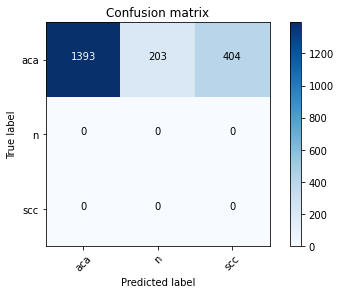

In [ ]:
#Plotting confusion matrix
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

## VGG_16 model 

In [ ]:
#Preprocessing the data to be appropriate for the model processing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128,shuffle=False)

#Downloading the model
vgg16_model = tf.keras.applications.vgg16.VGG16()

#Removing last layer from the VGG16 (known as fine tuning)
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

#Freezing the hidden layers from trianing
for layer in model.layers:
  layer.trainable = False

# Adding last layers which will give three possible answers corresponding to three classes of the cancer
model.add(Dense(units=3, activation='softmax'))

#setting hyperparameters and compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics='accuracy')

#Training the model by providing training and validation set
model.fit(x=train_batches,validation_data=valid_batches, epochs=5,verbose=2)

#saving the trained model 
model.save('VGG16_model.h5')

# Prediction using the trained model and giving the test batches
prediction = model.predict(x=test_batches, verbose=0)

#initializing confusion matrix with test batch classes and predicted outputs
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(prediction,axis=-1))
cm_plot_labels = ['aca','n','scc']

#Plotting confusion matrix
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

Found 12000 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
553476096/553467096 [==============================] - 3s 0us/step
Epoch 1/5
94/94 - 172s - loss: 0.4115 - accuracy: 0.8340 - val_loss: 0.2265 - val_accuracy: 0.9112 - 172s/epoch - 2s/step
Epoch 2/5
94/94 - 132s - loss: 0.2067 - accuracy: 0.9241 - val_loss: 0.1793 - val_accuracy: 0.9283 - 132s/epoch - 1s/step
Epoch 3/5
94/94 - 133s - loss: 0.1735 - accuracy: 0.9369 - val_loss: 0.1564 - val_accuracy: 0.9392 - 133s/epoch - 1s/step
Epoch 4/5
94/94 - 132s - loss: 0.1533 - accuracy: 0.9435 - val_loss: 0.1447 - val_accuracy: 0.9463 - 132s/epoch - 1s/step
Epoch 5/5
94/94 - 132s - loss: 0.1399 - accuracy: 0.9488 - val_loss: 0.1345 - val_accuracy: 0.9479 - 132s/epoch - 1s/step


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-5997c7cc77eb>", line 37, in <module>
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels)
NameError: name 'plot_confusion_matrix' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/py

NameError: ignored

## FASTAPI Deployment 

In [ ]:
!pip install colabcode
!pip install fastapi
!pip install python-multipart

In [ ]:
from colabcode import ColabCode
from fastapi import FastAPI, UploadFile, File

In [ ]:
cc = ColabCode(port=12000, code=False)

In [ ]:
app = FastAPI()

@app.on_event("startup")
def load_model():
    global model
    model = pickle.load(open("model.pkl", "rb"))

@app.get('/')
def index():
    return {'message': 'This is the homepage of the API '}


@app.post('/predict')
def get_music_category(data: Music):
    received = data.dict()
    pred_name = model.predict([[acousticness, danceability, energy,
                                instrumentalness, liveness, speechiness, tempo, valence]]).tolist()[0]
    return {'prediction': pred_name}

In [ ]:
class Music(BaseModel):
  import numpy as np, cv2 as cv
  def read_img(file):
    img = cv.imread(file)
    return img

RuntimeError: ignored

In [ ]:
%%writefile prediction.py
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.models import load_model

input_shape = (224,224)

def read_image(file):
  img = cv.imread(file)
  return img

def preprocess(img: np.ndarray):
  img = img.resize(input_shape)
  img = np.expand_dims(img,0)
  return img

def load_model():
  model = load_model('/content/drive/MyDrive/Models/resnet50_model.h5')
  return model
model = load_model()
def predict(img: np.ndarray):
  predictions = model.predict(img)
  print(predictions)
  return predictions

Overwriting prediction.py


In [ ]:
cc.run_app(app = app)

Public URL: NgrokTunnel: "https://bb65-34-73-180-139.ngrok.io" -> "http://localhost:12000"


INFO:     Started server process [1391]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:12000 (Press CTRL+C to quit)


INFO:     39.40.102.118:0 - "GET / HTTP/1.1" 404 Not Found
INFO:     39.40.102.118:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [1391]
